In [ ]:
import zipfile
import os

with zipfile.ZipFile('/content/drive/MyDrive/fer_datatset/test.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/sample_data/FER')

with zipfile.ZipFile('/content/drive/MyDrive/fer_datatset/val.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/sample_data/FER')

with zipfile.ZipFile('/content/drive/MyDrive/fer_datatset/train.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/sample_data/FER')

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None, excluded_labels=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pixels = self.data.iloc[idx]['pixels']
        emotion = self.data.iloc[idx]['emotion']
        image = self.str_to_image(pixels)

        if self.transform:
            image = self.transform(image)

        return image, emotion

    def str_to_image(self, str_img):
        imgarray_str = str_img.split(' ')
        imgarray = np.asarray(imgarray_str, dtype=np.uint8).reshape(48, 48)
        return Image.fromarray(imgarray)

# Define transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
train_dataset = CustomDataset('/content/sample_data/FER/train.csv', transform=transform)
val_dataset = CustomDataset('/content/sample_data/FER/val.csv', transform=transform)
test_dataset = CustomDataset('/content/sample_data/FER/test.csv', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)


In [ ]:
class Deep_Emotion(nn.Module):
    def __init__(self):
        super(Deep_Emotion, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3) #(input,output,no_of strides) # 48*48
        self.pool1 = nn.MaxPool2d(2, 2) # pixel size 24*24
        self.conv2 = nn.Conv2d(16, 32, 3) #(batchsize,no of channels ,output channels , filter size)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 10 * 10, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 7)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 32 * 10 * 10)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x



Using device: cuda
Epoch [1/10], Loss: 1.7399
Epoch [2/10], Loss: 1.5627
Epoch [3/10], Loss: 1.4833
Epoch [4/10], Loss: 1.4349
Epoch [5/10], Loss: 1.4058
Epoch [6/10], Loss: 1.3811
Epoch [7/10], Loss: 1.3600
Epoch [8/10], Loss: 1.3437
Epoch [9/10], Loss: 1.3252
Epoch [10/10], Loss: 1.3119


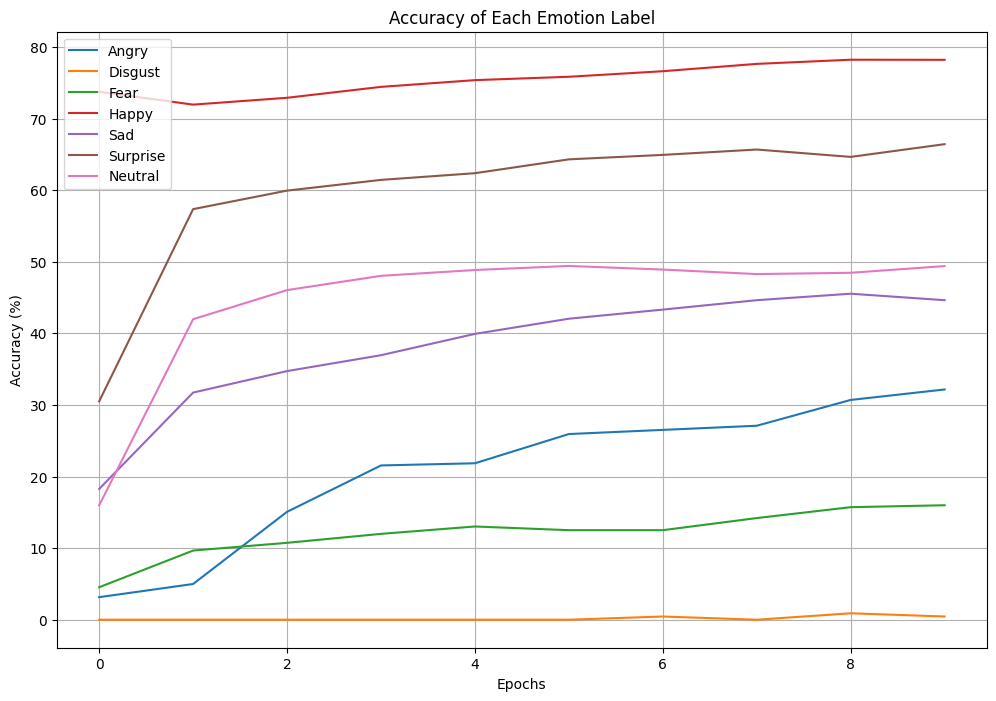

In [ ]:
# Define the model
model = Deep_Emotion()

# Checking if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return (correct / total) * 100

# Training loop
def train(model, train_loader, optimizer, criterion, epochs):
    train_losses = []
    train_accuracies = {i: [] for i in range(7)}  # Dictionary to store accuracy for each emotion

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        total_predictions = {i: 0 for i in range(7)}  # Count of total predictions for each emotion
        correct_predictions = {i: 0 for i in range(7)}  # Count of correct predictions for each emotion

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU if available
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Calculate accuracy for each emotion
            _, predicted = torch.max(outputs, 1)
            for i in range(7):
                mask = (labels == i)
                total_predictions[i] += mask.sum().item()
                correct_predictions[i] += (predicted[mask] == labels[mask]).sum().item()

        # Calculate accuracy for each emotion after each epoch
        for i in range(7):
            if total_predictions[i] != 0:
                acc = (correct_predictions[i] / total_predictions[i]) * 100
                train_accuracies[i].append(acc)
            else:
                train_accuracies[i].append(0.0)

        train_losses.append(running_loss/len(train_loader))

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}')

    return train_losses, train_accuracies

# Assuming you have train_loader defined
train_losses, train_accuracies = train(model, train_loader, optimizer, criterion, epochs=10)

# Plotting
emotions = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Sad",
    5: "Surprise",
    6: "Neutral"
}

plt.figure(figsize=(12, 8))
for i in range(7):
    plt.plot(train_accuracies[i], label=emotions[i])

plt.title('Accuracy of Each Emotion Label')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

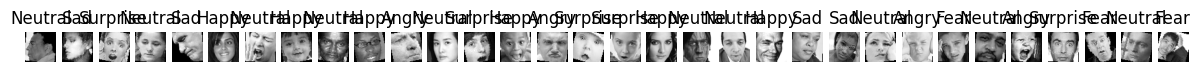

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_images_from_loader(loader, num_images=5):
    # Get a batch of images and labels
    for images, labels in loader:
        break  # Exit the loop after getting the first batch

    # Define the class labels (assuming integers representing emotions)
    emotions = {
        0: "Angry",
        1: "Disgust",
        2: "Fear",
        3: "Happy",
        4: "Sad",
        5: "Surprise",
        6: "Neutral"
    }

    # Plot the images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        # Convert images from tensors to numpy arrays and transpose if necessary
        image = images[i].numpy().squeeze()
        if len(image.shape) == 3:  # If image is RGB, transpose it
            image = np.transpose(image, (1, 2, 0))
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(emotions[labels[i].item()])
        axes[i].axis('off')

    plt.show()

# Assuming train_loader is defined
show_images_from_loader(filtered_train_loader, num_images=32)


[6, 5, 3]

cuda


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

NameError: name 'images' is not defined